In [145]:
import numpy as np
from qiskit import QuantumCircuit, transpile,assemble
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator

Before any coding first lets define our binonmial options tree class which we will use in the future when we actually price our options contracts

In [123]:
#specific nodes of the binomial tree
class bnNode:
    def __init__(self, val):
        self.val = val #price of the stock at certain point at root will be strike price
        self.up = None #points to an upmovemnt node
        self.down = None #points to a downmovement node

    def __repr__(self):
        return f"bnNode(val={self.val})" #printer function to print curr val of the stock at given point

#the tree itself
class BinomialTree:
    def __init__(self, S0, upSz, downSz, NumStps):
        self.root = bnNode(S0) # root node to the strike price
        self.upSz = upSz #percent by which stock price increases ie increase of 10% in one step => 1.1
        self.downSz = downSz #percent by which stock price decreases ie decrease of 10% in one step => 0.9
        self.NumStps = NumStps #total number of steps in the tree itself
        self.build_tree(self.root, 0)

    def build_tree(self, node, step):
        if step < self.NumStps:
            node.up = bnNode(node.val * self.upSz)
            node.down = bnNode(node.val * self.downSz)

            #recrusively build the rest of the tree
            self.build_tree(node.up, step + 1)
            self.build_tree(node.down, step + 1)




In [124]:

#simply defines an up-movement in stock price and by how much
def up_move(sigma, t):
    b = np.exp(sigma * np.sqrt(1/t)) - 1
    return b
def down_move(sigma, t):
    return np.exp(-sigma * np.sqrt(1/t)) - 1
#this consctructs the quantum operator whcih is a matrix
#that represents the possible price movements of the stock
#diagonal matrix
def build_quantum_op(up_factor, down_factor):
    A = np.array([[1+up_factor, 0], [0, 1+down_factor]])
    return A

# Parameters in math notation according to the paper
sigma = 0.1 #volatility
r = 0.05 #risk free interest rate
T = 1 # total time period
N = 3 #number of steps in the binomial model
t = T / N # time increment per step

b = up_move(sigma, t)  # up movement factor
down = down_move(sigma,t)
print(f"Calculated b: {b}")

A = build_quantum_op(b, down)
print(f"Quantum operator matrix A:\n{A}")

eigenvalues, eigenvectors = np.linalg.eigh(A)
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors:\n{eigenvectors}")



Calculated b: 0.18910994364714484
Quantum operator matrix A:
[[1.18910994 0.        ]
 [0.         0.84096513]]
Eigenvalues: [0.84096513 1.18910994]
Eigenvectors:
[[0. 1.]
 [1. 0.]]


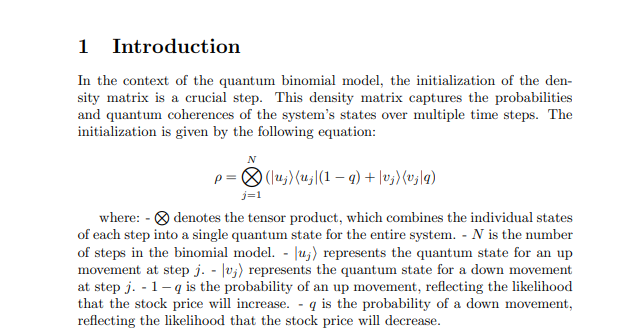

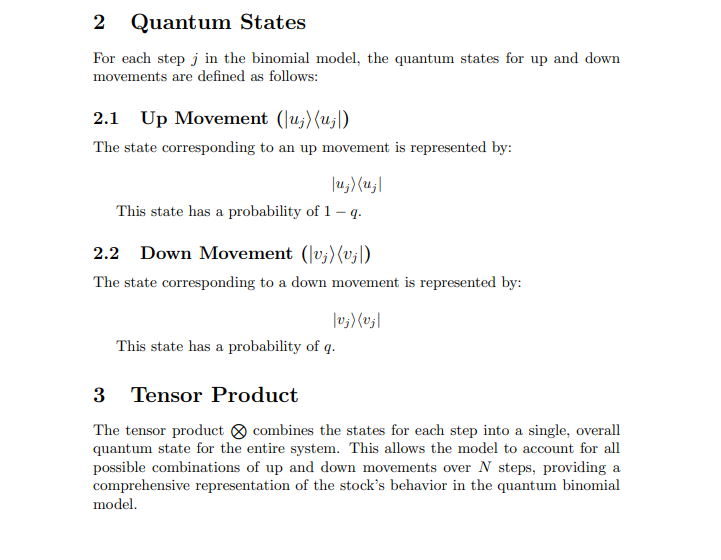

In [125]:
# Now we need to intialize density matrix using the
# eigenvectors and constructing mixed stat for each qubit

### MAJOR CHANGE 
###problem with the pricer only reutrning the og matrix wihtout 
### this code below so i added it and it seems to work testing needs to be 
### done to understand its significance and its function 
### and if it will price the option as intended

#######

# def update_density_matrix(density_matrix, quantum_op):
#     return np.dot(quantum_op, np.dot(density_matrix, quantum_op.T))


######


# #pass in a ref to our binomial options tree root node
# def buildDensityMatr(BinTree:BinomialTree,r,t):
#   intial_state = np.zeros(2**BinTree.NumStps,dtype=complex) #total number of states N is the number of steps in the model as such need 2^N states as each step has an up step and a down step


#   density_matrix = np.zeros((BinTree.NumStps + 1, BinTree.NumStps + 1))

# #Calculate q or the risk-neutral probability whcih we will represent by
# #the variable risk_neut_prob
#   risk_neut_prob = (np.exp(r*t) - BinTree.downSz)/(BinTree.upSz-BinTree.downSz)
#   print(f"Risk-neutral probability q: {risk_neut_prob}")

#   #recusively build the density matrix starting at the root node of the bintree and going throuhg the entire tree
#   #updating the matrix each way as it goes through each step

#   def recursive_build(node, step, prob):
#       if step > BinTree.NumStps:
#           return
#       density_matrix[step, step - prob] += prob
#       if node.up is not None and node.down is not None:
#           recursive_build(node.up, step + 1, prob * risk_neut_prob)
#           recursive_build(node.down, step + 1, prob * (1 - risk_neut_prob))

#   recursive_build(BinTree.root, 0, 1.0)
#   return density_matrix, risk_neut_prob
#   # def recursive_build(node,curr):
#   #     #ie no other nodes left so we make the matrix itself here 
#   #     if node.up is None and node.down is None:
#   #           # np.outer it a function that does an outer-product it will reutrn a matrix 
#   #           # this is going to construct the density matrix from the state with the first column of the eigenvector and its complex conjugate
#   #           # one example of an outer product and what it will look like is if we have: The outer product of [1, 0] and [1, 0] is: [[1*1, 1*0],[0*1,0*0]] resulting in [[1, 0],[0,0]]
#   #           #another representation is first row: [1*1, 1*0] second row: [0*1,0*0] resulting in first row [1,0] second row [0,0]
#   #        # return quantum_op
#   #        return curr
#   #         #return np.outer(eigenvectors[:, 0], np.conj(eigenvectors[:, 0])) #
#   #     else:
#   #         # Recursively build density matrices for child nodes
        
#   #         up_density = update_density_matrix(curr, quantum_op)
#   #         down_density = update_density_matrix(curr, quantum_op)
#   #         up_density = recursive_build(node.up, up_density)
#   #         down_density = recursive_build(node.down, down_density)
#           # up_density = recursive_build(node.up, quantum_op)
#           # down_density = recursive_build(node.down, quantum_op)
#           # print("up " + str(up_density))
#           # print("down" + str(down_density))
#           # we finally get to the end of the tree when we get to this line.  Then we can calculat the node density below and update the density matrix
#           # Then the up density and down Density will be a matrix itself that is going to be updated using the previous densities so 
          
#           # Calculate node density as weighted sum of up and down densities

#             #the best way to think of this is that when we get to the end of the tree ie last node or leaf node this leaf node points to nothing and is the end
#             # based on our binomial tree each node will either have two children or no children like a leaf node so this leaf node is either a up movement or a down movement
#             # visual:


#               #          __node1_up -> null
#               #        _/
#               #-node 1  
#               #       _
#               #        \
#               #         ⎻⎻ node1_down ->null
                        
#                   # the node1_up val will be unique from the node1 down because we are using the eigenvectors to represent different 
#                   #quantum states and so each leaf node corresponds to a unique state derived from the binomial tree's possible outcomes


#             # Example: if up_density = [[1, 0], [0, 0]] and down_density = [[0, 0], [0, 1]], with risk_neut_prob = 0.6
#             # node_density = 0.4 * [[1, 0], [0, 0]] + 0.6 * [[0, 0], [0, 1]]
#             #              = [[0.4, 0], [0, 0]] + [[0, 0], [0, 0.6]]
#             #              = [[0.4, 0], [0, 0.6]]

#           # print(1-risk_neut_prob)
#           # print(risk_neut_prob)
#           # print(1-risk_neut_prob+risk_neut_prob)
#          # node_density = (1 - risk_neut_prob) * up_density + risk_neut_prob * down_density
#           #print("node density" + str(node_density))
#          # return node_density

#     # Start recursion from the root node
#   # initial_density = np.identity(quantum_op.shape[0])
#   # root_density = recursive_build(BinTree.root,curr=initial_density)
#   # return root_density,risk_neut_prob

#   recursive_build(BinTree.root, 0, 1.0)
#   return density_matrix, risk_neut_prob
# Function to build the probability matrix for the binomial tree
def build_prob_matrix(bin_tree, r, t):
    risk_neut_prob = (np.exp(r * t) - bin_tree.downSz) / (bin_tree.upSz - bin_tree.downSz)
    prob_matrix = np.zeros((bin_tree.NumStps + 1, bin_tree.NumStps + 1))

    def recursive_build(node, step, up_steps, prob):
        if step > bin_tree.NumStps:
            return
        prob_matrix[step, up_steps] += prob
        if step < bin_tree.NumStps:
            recursive_build(node.up, step + 1, up_steps + 1, prob * risk_neut_prob)
            recursive_build(node.down, step + 1, up_steps, prob * (1 - risk_neut_prob))

    recursive_build(bin_tree.root, 0, 0, 1.0)
    return prob_matrix, risk_neut_prob

# Function to compute the option price using the probability matrix
def compute_option_price(prob_matrix, bin_tree, K, r, T):
    final_prices = np.array([bin_tree.root.val * (bin_tree.upSz ** (bin_tree.NumStps - i)) * (bin_tree.downSz ** i) for i in range(bin_tree.NumStps + 1)])
    payoffs = np.maximum(0, final_prices - K)
    expected_payoff = np.dot(prob_matrix[-1, :], payoffs)
    option_price = np.exp(-r * T) * expected_payoff
    return option_price


In [126]:
def run_test_case(S0, upSz, downSz, NumStps, sigma, r, T, K):
    t = T / NumStps
    up_factor = up_move(sigma, t)
    down_factor = down_move(sigma, t)
    print(f"Calculated up factor: {up_factor}, down factor: {down_factor}")
    bin_tree = BinomialTree(S0, upSz, downSz, NumStps)
    prob_matrix, risk_neut_prob = build_prob_matrix(bin_tree, r, t)
    print(f"Parameters: S0={S0}, upSz={upSz}, downSz={downSz}, NumStps={NumStps}, sigma={sigma}, r={r}, T={T}")
    print("Probability Matrix:")
    print(prob_matrix)
    option_price = compute_option_price(prob_matrix, bin_tree, K, r, T)
    print(f"Option Price: {option_price}")
    print("===================================================")
    return option_price

# Test Case 1: Basic Configuration
option_price = run_test_case(S0=100, upSz=1.1, downSz=0.9, NumStps=3, sigma=0.1, r=0.05, T=1, K=100)
print(f"Option Price for Test Case 1: {option_price}")
# Test Case 2: High Volatility
option_price2 = run_test_case(S0=100, upSz=1.2, downSz=0.8, NumStps=3, sigma=0.2, r=0.05, T=1, K=100)
print(f"Option Price for Test Case 2: {option_price2}")

Calculated up factor: 0.18910994364714484, down factor: -0.15903486860695293
Parameters: S0=100, upSz=1.1, downSz=0.9, NumStps=3, sigma=0.1, r=0.05, T=1
Probability Matrix:
[[1.         0.         0.         0.        ]
 [0.41596835 0.58403165 0.         0.        ]
 [0.17302967 0.48587736 0.34109297 0.        ]
 [0.07197486 0.30316441 0.42565164 0.19920909]]
Option Price: 4.832750799403532
Option Price for Test Case 1: 4.832750799403532
Calculated up factor: 0.41398245808051626, down factor: -0.29277764778107507
Parameters: S0=100, upSz=1.2, downSz=0.8, NumStps=3, sigma=0.2, r=0.05, T=1
Probability Matrix:
[[1.         0.         0.         0.        ]
 [0.45798417 0.54201583 0.         0.        ]
 [0.2097495  0.49646934 0.29378116 0.        ]
 [0.09606195 0.34106265 0.40364136 0.15923404]]
Option Price: 11.58356063999828
Option Price for Test Case 2: 11.58356063999828


##
The below code is still to be completed the above code should work
##

In [127]:
qc = QuantumCircuit(N,N)

for i in range(N):
    qc.h(i)  # Apply Hadamard gate to create superposition

# Apply quantum gates to represent up and down movements
for i in range(N):
    theta = 2 * np.arccos(np.sqrt(risk_neut))  # Calculate the rotation angle for risk-neutral probability
    qc.ry(theta, i)  # Apply Ry gate to create the correct probability distribution

# Measure the final state
qc.measure(range(N), range(N))



def initialize_quantum_circuit(N, risk_neut_prob):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.h(i)  # Apply Hadamard gate to create superposition
    for i in range(N):
        theta = 2 * np.arccos(np.sqrt(risk_neut_prob))  # Calculate the rotation angle for risk-neutral probability
        qc.ry(theta, i)  # Apply Ry gate to create the correct probability distribution
    qc.measure(range(N), range(N))
    return qc

In [129]:
bin_tree = BinomialTree(S0=100, upSz=1.1, downSz=0.9, NumStps=3)
prob_matrix, risk_neut_prob = build_prob_matrix(bin_tree, r, t)
qc = initialize_quantum_circuit(N, risk_neut_prob)

simulator = AerSimulator()  # Corrected simulator initialization
compiled_circuit = transpile(qc, simulator)
qobj = assemble(compiled_circuit, shots=1024)
result = simulator.run(qobj).result()
counts = result.get_counts()

# Print the quantum circuit results
print(f"Quantum Circuit Result Counts: {counts}")


Quantum Circuit Result Counts: {'111': 999, '101': 8, '011': 11, '110': 6}


C:\Users\chaha\AppData\Local\Temp\ipykernel_16248\3020034128.py:8: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


In [130]:
# Compute the option price
payoffs = []
probabilities = []

S0 = 100
upSz = 1.1
downSz = 0.9
NumStps = 3
sigma = 0.1
r = 0.05
T = 1
K = 100

for outcome, count in counts.items():
    # Convert binary string to stock price
    final_price = S0 * (upSz ** outcome.count('1')) * (downSz ** outcome.count('0'))
    payoff = max(0, final_price - K)  # Call option payoff
    probability = count / 1024  # Probability of the outcome
    payoffs.append(payoff)
    probabilities.append(probability)

# Calculate the expected payoff and discount to present value
expected_payoff = np.dot(payoffs, probabilities)
option_price = np.exp(-r * T) * expected_payoff

print("Option Price:", option_price)


Option Price: 30.923688285130975


{'100': 113, '110': 132, '011': 145, '000': 122, '001': 142, '010': 119, '101': 118, '111': 109}


C:\Users\chaha\AppData\Local\Temp\ipykernel_9516\2237938607.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


In [189]:

class bnNode:
    def __init__(self, val):
        self.val = val
        self.up = None
        self.down = None

    def __repr__(self):
        return f"bnNode(val={self.val})"

class BinomialTree:
    def __init__(self, S0, upSz, downSz, NumStps):
        self.root = bnNode(S0)
        self.upSz = upSz
        self.downSz = downSz
        self.NumStps = NumStps
        self.build_tree(self.root, 0)

    def build_tree(self, node, step):
        if step < self.NumStps:
            node.up = bnNode(node.val * self.upSz)
            node.down = bnNode(node.val * self.downSz)
            self.build_tree(node.up, step + 1)
            self.build_tree(node.down, step + 1)

def up_move(sigma, t):
    return np.exp(sigma * np.sqrt(t))

def down_move(sigma, t):
    return np.exp(-sigma * np.sqrt(t))

def build_quantum_op(up_factor, down_factor):
    theta_up = np.arccos(1 - up_factor)
    theta_down = np.arccos(1 - down_factor)
    A = np.array([[np.cos(theta_up), -np.sin(theta_up)], [np.sin(theta_up), np.cos(theta_up)]])
    return A

def build_density_matrix(bin_tree, r, t):
    risk_neut_prob = (np.exp(r * t) - bin_tree.downSz) / (bin_tree.upSz - bin_tree.downSz)
    density_matrix = np.array([[risk_neut_prob, 0], [0, 1 - risk_neut_prob]], dtype=complex)
    return density_matrix, risk_neut_prob

def initialize_quantum_circuit(num_qubits, density_matrix):
    qc = QuantumCircuit(num_qubits, num_qubits)
    state_vector = np.sqrt(np.diag(density_matrix))
    state_vector = state_vector / np.linalg.norm(state_vector)  # Normalize the state vector
    qc.initialize(state_vector, range(num_qubits))
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

def compute_option_price_quantum(counts, bin_tree, K, r, T):
    final_prices = []
    for state, count in counts.items():
        up_moves = state.count('1')
        down_moves = state.count('0')
        final_price = bin_tree.root.val * (bin_tree.upSz ** up_moves) * (bin_tree.downSz ** down_moves)
        final_prices.append((final_price, count))
    
    total_counts = sum(counts.values())
    payoffs = np.maximum(0, [price - K for price, _ in final_prices])
    weighted_payoffs = [payoff * count / total_counts for payoff, (_, count) in zip(payoffs, final_prices)]
    expected_payoff = np.sum(weighted_payoffs)
    option_price = np.exp(-r * T) * expected_payoff
    return option_price

def run_test_case(S0, upSz, downSz, NumStps, sigma, r, T, K):
    t = T / NumStps
    up_factor = up_move(sigma, t) - 1
    down_factor = down_move(sigma, t) - 1

    bin_tree = BinomialTree(S0, upSz, downSz, NumStps)
    density_matrix, risk_neut_prob = build_density_matrix(bin_tree, r, t)

    # Quantum Circuit Initialization and Simulation
    num_qubits = int(np.log2(density_matrix.shape[0]))
    qc = initialize_quantum_circuit(num_qubits, density_matrix)
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    qobj = assemble(compiled_circuit, shots=10000)
    result = simulator.run(qobj).result()
    counts = result.get_counts()

    option_price_quantum = compute_option_price_quantum(counts, bin_tree, K, r, T)
    return option_price_quantum

# Test Case: Basic Configuration
option_price_quantum = run_test_case(S0=100, upSz=1.1, downSz=0.9, NumStps=46, sigma=0.1, r=0.05, T=1, K=100)
print(f"Option Price for Test Case - Quantum: {option_price_quantum}")